# Text Classification 1: Imbalanced Data
------------------

## Table of Contents

__[1. Introduction](#first-bullet)__

__[2. The Dataset: Creating, Storing and Exploring](#second-bullet)__

__[3. TF-IDF: Preprocessing & Feature Extraction](#third-bullet)__

__[4. The Naive Bayes Model](#fourth-bullet)__

__[5. Imablanced Learn: Fixing Imbalanced Data](#fifth-bullet)__

__[6. Weighted Support Vector Machines ](#sixth-bullet)__

__[9. Next Steps](#seventh-bullet)__


---------

## Introduction <a class="anchor" id="first-bullet"></a>
-----------

Natural language processing (NLP) is an hot topic in data science and machine learning.  While research in NLP dates back to the 1950's, the real revolution in this domain came in 1980's and 1990's with the introduction of statistical models and fast computational power. Before this most language processing tasks made use of hand-coded rules which were generally not very robust.

The span of topics in Natural Language Processing is immense and I'll just getting to the tip of the iceberg with the topic of [document classification](https://en.wikipedia.org/wiki/Document_classification), also known as [text classification](https://monkeylearn.com/text-classification/). I will be working with the <a href="http://scikit-learn.org/">Scikit-learn</a> library and an imbalanced dataset (corpus) that I will create from summaries of papers published on [arxiv](https://arxiv.org). The topic of each paper is already labeled as the category therefore alleviating the need for me to label the dataset. The imbalance in the dataset will be caused by the imbalance in the number of samples in each of the categories we are trying to predict. Imbalanced data occurs quite frequently in classification problems and makes developing a good model more challenging. Often times it is too expensive or not possible to get more data on the classes that have too few samples. Developing strategies for dealing with imbalanced data is therefore paramount for creating a good classification model.  We will cover some of the basics of dealing with imbalanced data using the [Imbalance-Learn](https://imbalanced-learn.readthedocs.io/en/stable/) library using Naive Bayes and Support Vector classifier from <a href="http://scikit-learn.org/">Scikit-learn</a>. In the next post we'll dive more int NLP with the Natural Language Tool Kit ([NLTK](https://www.nltk.org/)).


Let's dive into the data! 

## The Dataset: Creating, Storing and Exploring<a class="anchor" id="second-bullet"></a>

The first thing I wanted to do was create a database to store the data between working sessions on this project. Storing the dataset means that I wouldn't have to re-download the data each time I run the notebook. I chose to create a local [MongoDB](https://www.mongodb.com/) database since its easy to use and I have [experience](https://api.mongodb.com/python/current/) with it and [PyMongo](https://api.mongodb.com/python/current/). 

We can create a client with pymongo and create a new database using the commands: 

In [1]:
import pymongo
conn = pymongo.MongoClient('mongodb://localhost:27017')
db   = conn.db_arxiv

Now that we have to actually collect the data.  We will use the Python library [arxiv](https://github.com/lukasschwab/arxiv.py) to allow us to collect data from the [arxiv api](https://arxiv.org/help/api):

In [2]:
import arxiv

We will focus on only four sub topics of Computer Science in this blogpost:
    
* Artificial Intelligence
* Machine Learning
* Computer Vision
* Robotics
    
These topics are somewhat related, but different enough that I expect there to be significant differences in the words used in the summaries of the papers. The only exception being machine learning and artifical intelligence are used somewhat interchangably and I expect there to be some overlap in there words. In all I expect pretty good performance for our future model. 

Let's query the the arxiv api and create a list of dictionaries for each topic. Each dictionary will correspond to a paper on arxiv. Each dictionary will include,

1. The link to the paper
2. The category code arxiv gave for this papers topic
3. The label for this category
4. The text of the summary for this paper.

Let's collect 2000 articles on artificial intelligence, machine learning and computer vision as well as 300 topics on robotics:

In [4]:
# artificial intelligence
ai_results = [{'link'     : doc['id'],
               'code'     : doc['arxiv_primary_category']['term'],
               'category' : 'ai',
               'text'     : doc['summary']}
             for doc in arxiv.query(query='cat:cs.AI', max_results=2000)]

# machine learning
ml_results = [{'link'     : doc['id'],
               'code'     : doc['arxiv_primary_category']['term'],
               'category' : 'ml',
               'text'     : doc['summary']}
              for doc in arxiv.query(query='cat:cs.LG', max_results=2000)]

# computer visison
cv_results = [{'link'     : doc['id'],
                'category' : 'cv',
                'code'     : doc['arxiv_primary_category']['term'],
                'text'     : doc['summary']}
              for doc in arxiv.query(query='cat:cs.CV', max_results=2000)]

# robotics
ro_results = [{'link'     : doc['id'],
                 'category' : 'ro',
                 'code'     : doc['arxiv_primary_category']['term'],
                 'text'  : doc['summary']}
              for doc in arxiv.query(query='cat:CS.RO', max_results=300)]

We can look at some the results:

In [268]:
cv_results[89]

{'link': 'http://arxiv.org/abs/0907.0204v1',
 'category': 'cv',
 'code': 'cs.CV',
 'text': 'There are many applications of graph cuts in computer vision, e.g.\nsegmentation. We present a novel method to reformulate the NP-hard, k-way graph\npartitioning problem as an approximate minimal s-t graph cut problem, for which\na globally optimal solution is found in polynomial time. Each non-terminal\nvertex in the original graph is replaced by a set of ceil(log_2(k)) new\nvertices. The original graph edges are replaced by new edges connecting the new\nvertices to each other and to only two, source s and sink t, terminal nodes.\nThe weights of the new edges are obtained using a novel least squares solution\napproximating the constraints of the initial k-way setup. The minimal s-t cut\nlabels each new vertex with a binary (s vs t) "Gray" encoding, which is then\ndecoded into a decimal label number that assigns each of the original vertices\nto one of k classes. We analyze the properties of the

We can see that there are some '\n' sprinkled in the summary text; removing these is actually taken care of in the libraries that we use.


### Storing The Train and Test Set

The four topics we are trying to predict are also called the target classes or simply the classes. We refer to artifical intelligence, machine learning and computer vision as the "majority classes" and robotics as the "minority class" due to the discrepencies in the number of datapoints.  Let's break out data set into a 75% training and 25% testing.  We create the training set:

In [9]:
maj_train = 1500
min_train = 225

train = ai_results[0:maj_train]  + ml_results[0:maj_train] +\
        cv_results[0:maj_train] + ro_results[0:min_train]

And then insert them into the MongoDB databases as the `training collection`:

In [10]:
# insert them into training collection
db.train_cs_papers.insert_many(train, ordered=False)

We then do the same for the test set:

In [11]:
test = ai_results[maj_train-1 :-1] + ml_results[maj_train-1:-1] +\
       cv_results[maj_train-1:-1] + ro_results[min_train-1:-1]

# insert them into training collection
db.test_cs_papers.insert_many(test, ordered=False)

Now that we have stored the datasets, let's read them back and connvert them to a Pandas dataframe:

In [5]:
import pandas as pd

# projection for subselecting only `text` and `category` fields
project = {"_id":0,"text":1,"category":1}

# get the training set
train_df = pd.DataFrame(db.train_cs_papers.find({},project))

# get the testing set
test_df = pd.DataFrame(db.test_cs_papers.find({},project))

Let's take a look what the dataframes look like:

In [6]:
train_df.head()

,category,text
0,ai,Because of their occasional need to return to ...
1,ai,Market price systems constitute a well-underst...
2,ai,We describe an extensive study of search in GS...
3,ai,As real logic programmers normally use cut (!)...
4,ai,To support the goal of allowing users to recor...


We can see the total number of papers we have:

In [7]:
train_df.shape[0] + test_df.shape[0] 

6300

In order for our model to predict the topic of each summary we need to convert the category into a number.  For that we use the Scikit-Learn [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class.  We append a new column to the dataframe called `target` that will be the numerical value of the class:

In [8]:
from sklearn.preprocessing import LabelEncoder  

labeler = LabelEncoder()
train_df["target"] = labeler.fit_transform(train_df["category"])
test_df["target"]  = labeler.transform(test_df["category"])

In order to view the human readible version of the target we create a dictionary to map the categorical variables (numbers) to labels:

In [9]:
mapping = dict(zip(labeler.classes_, range(len(labeler.classes_))))
print(mapping)

{'ai': 0, 'cv': 1, 'ml': 2, 'ro': 3}


Let's take a look at the number of samples in the training and test set:

In [10]:
train_cts = train_df.groupby("target").size()
test_cts  = test_df.groupby("target").size()

Text(0, 0.5, 'Counts')

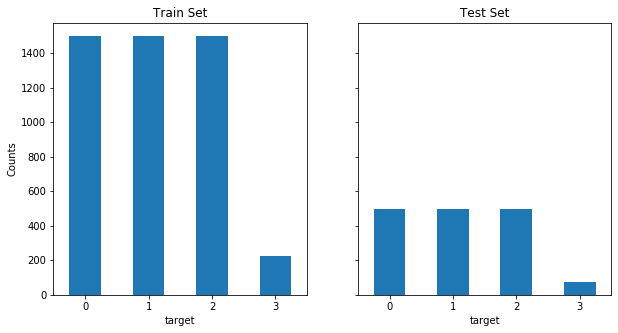

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
train_cts.plot(kind='bar',ax= ax1,rot=0)
test_cts.plot(kind='bar',ax= ax2,rot=0)
ax1.set_title('Train Set')
ax2.set_title('Test Set')
ax1.set_ylabel("Counts")

In terms of percentages they are the exact same percentage of target classes: 

Text(0, 0.5, '%')

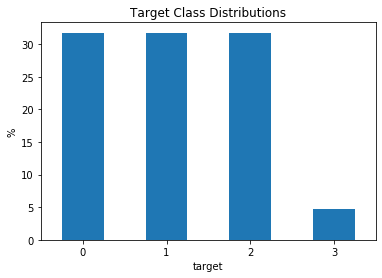

In [12]:
percents = 100 * train_df.groupby("target").size() / train_df.shape[0]

percents.plot(kind='bar', title='Target Class Distributions', rot=0)
plt.ylabel("%")
              

We can see that classes 0, 1, 2 are pretty even, but class 3 is much smaller than the other, the imbalance in the number of samples in the classes is what we mean by imbalanced data.  We can look an example article summary and its target value:

In [13]:
print("Category:\n{}\n".format(train_df["category"][5]))
print("Target: {}\n".format(train_df["target"][5]))
print("Text:\n", train_df["text"][5])

Category:
ai

Target: 0

Text:
 Terminological knowledge representation systems (TKRSs) are tools for
designing and using knowledge bases that make use of terminological languages
(or concept languages). We analyze from a theoretical point of view a TKRS
whose capabilities go beyond the ones of presently available TKRSs. The new
features studied, often required in practical applications, can be summarized
in three main points. First, we consider a highly expressive terminological
language, called ALCNR, including general complements of concepts, number
restrictions and role conjunction. Second, we allow to express inclusion
statements between general concepts, and terminological cycles as a particular
case. Third, we prove the decidability of a number of desirable TKRS-deduction
services (like satisfiability, subsumption and instance checking) through a
sound, complete and terminating calculus for reasoning in ALCNR-knowledge
bases. Our calculus extends the general technique of constra

Now lets take a look a the most commonly used words in each target class using a [word cloud](https://amueller.github.io/word_cloud/)

In [14]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(df: pd.DataFrame, category: str, target: int)-> None:
    words = " ".join(train_df[train_df["target"] == target]["text"].values)

    plt.rcParams['figure.figsize'] = 10, 20
    wordcloud = WordCloud(stopwords=STOPWORDS, 
                          background_color="white",
                          max_words=1000).generate(words)

    plt.title("WordCloud For {}".format(category))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

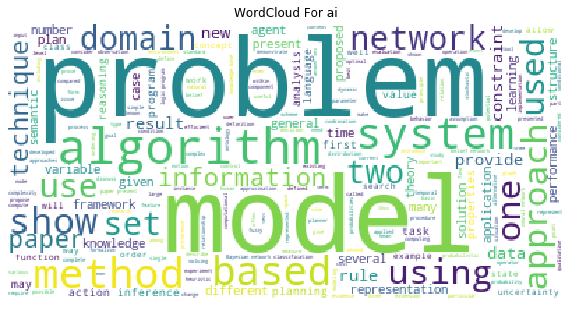

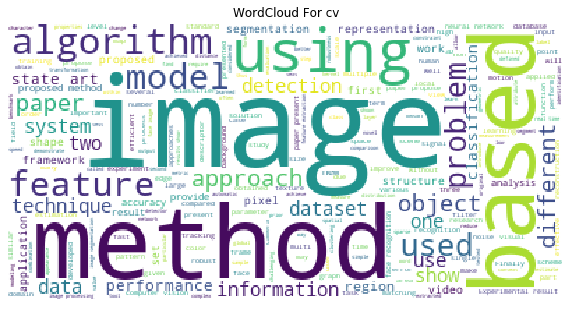

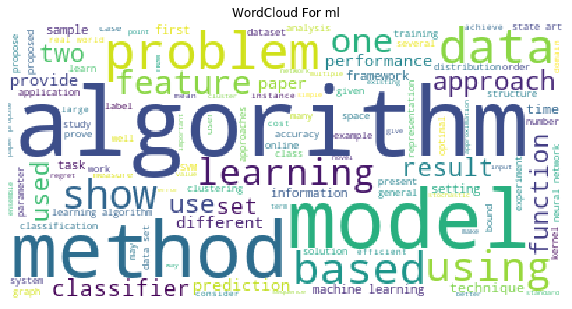

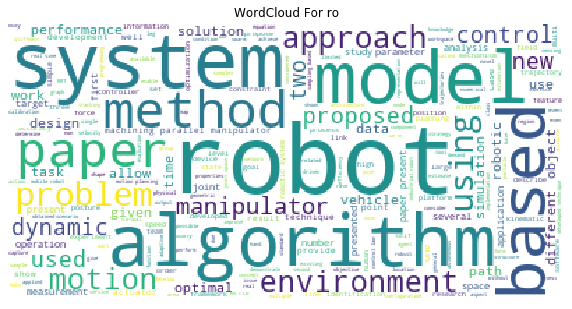

In [15]:
for category, target in mapping.items():
    plot_wordcloud(train_df, category, target)

We can see that some of the most common words to each topic (i.e. "problem", "model", "algorithm") are commonly occuring across topics. If we run into issues with our model performance we may consider including these common words as stop words.


Now that we have an idea of what kind of data we are working with we can start to do some machine learning on it.  As with all datasets there is some required preprocessing before machine learning.  With numerical data there needs to be some cleaning and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html">scaling</a> of the features. However, in Natural Language Processing there is much more substantial preprocessing stage that we'll go over next.

##  TF-IDF: Preprocessing & Feature Extraction <a class="anchor" id="third-bullet"></a>
--------------------

The first thing we need to go over is the concept of the <a href="https://en.wikipedia.org/wiki/Bag-of-words_model">**bag of words model**</a>.  *In the bag-of-words model, a text (such as a sentence or a document) is represented as "bag" or list of its words, disregarding grammar and even word order, but keeping multiplicity of the words.*  A two document example is:

- **D1:**  Hi, I am Mike and I like Boston.

- **D2:**  Boston is a city and people in Boston like the Red Sox.

From these two documents, a list, or 'bag-of-words' is constructed

    bag = ['Hi', 'I', 'am', 'Mike', 'and', 'like', 'Boston', 'is', 
           'a', 'city, 'and', 'people', 'in', 'the', 'red', 'sox]


Notice how in our bag-of-words we have dropped repetitions of the words 'I', 'is' and 'Mike', we will show how multiplicity of words enters into our model next. 

The bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the document.  In order to do so we have to generate a vector for each document that represents the number of times each entry in the bag of words appears in the text. The order of entries in the vector corresponds to the order of the entries in the bag-of-words list.  For example, document D1 would have a vector,

    [1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0 ,0, 0, 0, 0, 0]
    
while the second document, D2, would have the vector,

    [0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

Each entry of the lists refers to frequency or count of the corresponding entry in the bag-of-words list.  When we have a stacked collection of (row) vectors, or matrix, where each row corresponds to a document (vector), and each column corresponds to a word in the bag-of-words list, then this will be known as our **term-frequency ($\text{tf}$) [document matrix](https://en.wikipedia.org/wiki/Document-term_matrix)**. The general formula for an entry in the $\text{tf}$ matrix is,

$$\text{tf}(d,t) \,  = \, f_{t,d}$$
    
where $f_{t,d}$ is the number of times the term $t$ occurs in document $d \in \mathcal{D}$, where $\mathcal{D}$ is our text corpus. We can create a term-frequency matrix for the above example using Scikit-learns <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer">CountVectorizer</a> class:

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer =  CountVectorizer()

corpus     = ["Hi, I am Mike and I like Boston.",
              "Boston is a city and people in Boston like the Red Sox."]

# get the term frequency
tf  = vectorizer.fit_transform(corpus)

# get the words in bag-of-words
print(vectorizer.get_feature_names())

# get the counts!
print(tf.toarray())

['am', 'and', 'boston', 'city', 'hi', 'in', 'is', 'like', 'mike', 'people', 'red', 'sox', 'the']
[[1 1 1 0 1 0 0 1 1 0 0 0 0]
 [0 1 2 1 0 1 1 1 0 1 1 1 1]]


The order of the words is off and CountVectorizer dropped single letter words and punctutation, but the rest is the same!

**Notice CountVectorizer converts everything to lowercase, drops single letter words and punctuation.**

Let's try CountVectorizer on our dataset:

In [17]:
count_vect = CountVectorizer()

X_train_tf = count_vect.fit_transform(train_df["text"])

print("Shape of term-frequency matrix:", X_train_tf.shape)

Shape of term-frequency matrix: (4725, 18840)


The term-frequency is a sparse matrix where each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list. This can be confirmed by comparing the number of rows in the term-frequency matrix to the number of documents in the training set:

In [18]:
print("Number of training documents: ", train_df.shape[0])

Number of training documents:  4725


Most often term-frequency alone is not a good measure of the importance of a word/term to a document's topic.  Very common words like "the", "a", "to" are almost always the terms with the highest frequency in the text. Thus, having a high raw count of the number of times a term appears in a document does not necessarily mean that the corresponding word is more important. Furtermore, longer documents could have high frequency of terms that do not correlate with the document topic, but instead occur with high numbers solely due to the length of the document.

To circumvent the limination of term-frequency, we often normalize it by the **inverse document frequency (idf)**.  This results in the **term frequency-inverse document frequency (tf-idf)** matrix.  The *inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents in the corpus*.  We can give a formal defintion of the inverse-document-frequency by letting $\mathcal{D}$ be the corpus or the set of all documents and $N$ is the number of documents in the corpus and $N_{t,D}$ be the number of documents that contain the term $t$ then, 

$$idf(t,\mathcal{D}) \, = \,  \log\left(\frac{N_{\mathcal{D}}}{1 + N_{t,\mathcal{D}}}\right) \, = \, -  \log\left(\frac{1 + N_{t,\mathcal{D}}}{N_{\mathcal{D}}}\right) $$

The reason for the presence of the $1$ is for smoothing.  Without it, if the term/word did not appear in any training documents, then its inverse-document-frequency would be $idf(t,\mathcal{D}) = \infty$.  However, with the presense of the $1$ it will now have $idf(t,\mathcal{D}) = 0$.


Now we can formally defined the term frequnecy-inverse document frequency as a normalized version of term-frequency,


$$\text{tf-idf}(t,d) \, = \, tf(t,d) \cdot idf(t,\mathcal{D}) $$

Like the term-frequency, the term frequency-inverse document frequency is a sparse matrix, where again, each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list.  The $\text{tf-idf}$ matrix can be constructed using the sklearn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html">TfidfTransformer</a> class:

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape

(4725, 18840)

We should note that the $\text{tf-idf}$ matrix is the same shape as the $\text{tf}$ matrix, but the two have different values.


Now that we have built our $\text{tf-idf}$ matrix we can start to look at the which terms/words are most associated with document topics and then build a predictive model to classify the documents' topic. Let's first go over the model we will be using for prediction.

## The Naive Bayes Model <a class="anchor" id="fourth-bullet"></a>
-------------------

One of the most basic models for text classification is the <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier">Naive Bayes model</a>. The Naive Bayes classification model predicts the document topic, $y = \{C_{1},C_{2},\ldots, C_{k}\}$ where $C_{k}$ is the class or topic based on the document feactures $\textbf{x} \in \mathbb{N}^{p}$,  and $p$ is the number of terms in our bag-of-words list.  The feature vector,

$$\textbf{x} \, = \, \left[ x_{1}, x_{2}, \ldots , x_{p} \right] $$

contains counts $x_{i}$ for the $\text{tf-idf}$ value of the i-th term in our bag-of-words list.  Using <a href="https://en.wikipedia.org/wiki/Bayes%27_theorem">Bayes Theorem</a> we can develop a model to predict the topic class  ($C_{k}$) of a document from its feature vector $\textbf{x}$,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right)P(C_{k})}{P\left(x_{1}, \ldots, x_{p} \right)}$$

The Naive Bayes model makes the "Naive" assumption the probability of each term's $\text{tf-idf}$ is **conditionally independent** of every other term.  This reduces our **conditional probability function** to the product,

$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \; = \; \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$

Subsequently Bayes' theorem for our classification problem becomes,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{ P(C_{k}) \, \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)}{P\left(x_{1}, \ldots, x_{p} \right)}$$


Since the denominator is independent of the class ($C_{k}$) we can use a <a href="https://en.wikipedia.org/wiki/Maximum_a_posteriori">Maxmimum A Posteriori</a> method to estimate the document topic , 

$$ \hat{y} \, = \, \text{arg max}_{k}\;  P(C_{k}) \,  \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$ 


The **prior**, $P(C_{k}),$ is often taken to be the relative frequency of the class in the training corpus, while the form of the conditional distribution $P\left(x_{i} \, \vert \, C_{k} \right)$ is a choice of the modeler and determines the type of Naive Bayes classifier. 


We will use a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB">multinomial Naive Bayes</a> model which works well when our features are discrete variables such as those in our $\text{tf-idf}$ matrix.  In the multinomial Naive Bayes model the conditional probability takes the form,


$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \, = \, \frac{\left(\sum_{i=1}^{p} x_{i}\right)!}{\Pi_{i=1}^{p} x_{i}!}  \Pi_{i=1}^{p} p_{k,i}^{x_{i}}$$


where $p_{k,i}$ is the probability that the $k$-th class will have the $i$-th bag-of-words term in its feature vector. This leads to our **posterior distribution** having the functional form,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{ P(C_{k})}{P\left(x_{1}, \ldots, x_{p} \right)} \, \frac{\left(\sum_{i=1}^{p} x_{i}\right)!}{\Pi_{i=1}^{p} x_{i}!}  \Pi_{i=1}^{p} p_{k,i}^{x_{i}}$$

The Naive Bayes classifier can be fast compared to more sophisticated methods due to the decoupling of the class conditional feature distributions, i.e.

$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \; = \; \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$

**The decoupling of the class conditional distributions allows for each distribution to be independently estimated as a one dimensional distribution and helps to alleviate problems with the curse of dimensionality.**

We can instantiate a multinomial Naive Bayes classifier using the Scikit-learn library and fit it to our  $\text{tf-idf}$ matrix using the commands,

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

model = MultinomialNB()
model.fit(X_train_tfidf, train_df["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

The term `alpha=1` means we are using <a href="https://en.wikipedia.org/wiki/Laplace_smoothing">Laplace smoothing</a>. We can now look at the accuracy of our classifier using Scikit-learns <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html">accuracy_score</a> function:

In [21]:
X_test_tf = count_vect.transform(test_df["text"])
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

predicted = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(test_df["target"], predicted))

Accuracy: 0.8539682539682539


About 85% which is very good!  We can get more a detailed view of the performance of our classifier by using the Scikit-learn library's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html">classification report</a> function,

In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_df["target"],
                            predicted, 
                            target_names=mapping))

              precision    recall  f1-score   support

          ai       0.90      0.87      0.89       500
          cv       0.86      0.91      0.88       500
          ml       0.80      0.91      0.85       500
          ro       0.00      0.00      0.00        75

    accuracy                           0.85      1575
   macro avg       0.64      0.67      0.66      1575
weighted avg       0.82      0.85      0.83      1575



/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Whoa our precision and recall for robotics is terrible!

At 85% our accuracy is fairly high even though we are failing at classifying robotics at all. This is because accuracy is not a good measure for a classifiers performance when the data is imbalanced! Let's look at the [Reciever Operator Characteristic (ROC) Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [precision recall curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/) to get a visual representation of our model's performance. 

Note that in order to do so we need to convert the labels for our model using the [label_binarize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html) function:

In [23]:
from sklearn.preprocessing import label_binarize
import numpy as np

# get the number of classes
n_classes = len(train_df["target"].unique())

# classes = [0,1,2,3]
classes   = np.sort(train_df["target"].unique())

# relabel the test set
y_test = label_binarize(test_df["target"], 
                        classes=classes)

We can take a look a the first few entries of the newly labeled data:

In [24]:
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

We then get the probabilities of belonging to each class for the text documents:

In [25]:
y_pred = model.predict_proba(X_test_tfidf)

In [26]:
y_pred[:2]

array([[7.48853747e-01, 7.98500749e-02, 1.71074673e-01, 2.21505375e-04],
       [8.89897204e-01, 3.06915612e-02, 7.92791623e-02, 1.32072361e-04]])

Since class 0 has the highest probabilies, the model will predict the first two texts are artificial intelligence which is correct! Adapting the code from scikit-learn (ROC [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)) and (precision/recall [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)) I wrote the function `plot_roc_pr` to plot both of these in the same figure:

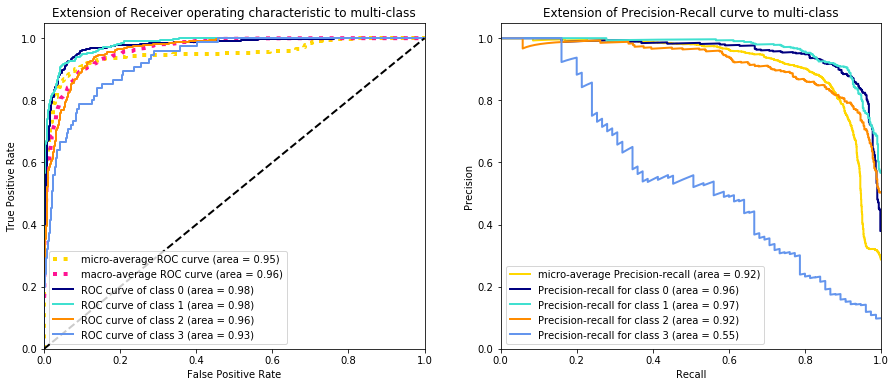

In [27]:
from Plot_ROC_PR_Curve import plot_roc_pr

plot_roc_pr(y_pred = y_pred, y_test = y_test)

We can see the ROC curve for robotics (class 3) isnt quite so bad, but the precision recall is terrible. This is due to the imbalance in our dataset and shows how important the precision recall curve is!  We can get better idea of how well our model is performing using the [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html):

In [28]:
from sklearn.metrics import balanced_accuracy_score

print("balanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                   predicted))

balanced_accuracy 0.6725


This seems more true to what we are seeing from the classification report.  We can also use the [f1 score](https://en.wikipedia.org/wiki/F1_score) which is balances the precision and recall into one score.  This makes sense to use as we want to increase both precision and recall, albiet for different classes.  Since the classes are imbalanced we will use the weighted f1 score:

In [29]:
from sklearn.metrics import f1_score

print("weighted f1 score:", f1_score(test_df["target"], 
                                     predicted, 
                                     average="weighted"))

weighted f1 score: 0.8335954423950264


We can see that the balanced accuracy is much better representation of how our model is performing than plain accuracy!  We'll try to improve our models performance using some more advanced preprocessing techniques.  This will be made much easier by using the concept of Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">pipeline</a> utility.

### Scikit-learn Pipelines
---------------

In Scitkit-learn pipelines are a sequence of transformations followed by a final estimator. Intermediate steps within the pipeline must be ‘transform’ methods, that is, they must implement fit and transform methods. The <code>CountVectorizer</code> and <code>TfidfTransformer</code> are used as transformers in our above example.  The final estimator of a pipeline only needs to implement the fit method.  We can see the simplicity of pipelines by using it to re-implement our above analysis using the Naive Bayes model:

In [30]:
from sklearn.pipeline import Pipeline

pipe  = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', MultinomialNB())])

model = pipe.fit(train_df["text"], train_df["target"])

pred  = model.predict(test_df["text"])

print(classification_report(test_df["target"],
                            pred, 
                            target_names=mapping))

              precision    recall  f1-score   support

          ai       0.90      0.87      0.89       500
          cv       0.86      0.91      0.88       500
          ml       0.80      0.91      0.85       500
          ro       0.00      0.00      0.00        75

    accuracy                           0.85      1575
   macro avg       0.64      0.67      0.66      1575
weighted avg       0.82      0.85      0.83      1575



/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Notice how when using pipelines we passed `train_df` and `test_df` into the `fit` and predict methods instead of the `X_train_tfidf` and `X_test_tfidf` objects as we did in the previous section. The transformations occur under-the-hood using the Scikit-learn pipeline functionality.  

## Imbalanced Learn: Fixing Imbalanced Data <a class="anchor" id="fifth-bullet"></a>
-----------------

Class imbalance of our data causes our model to underperform and there is not one clear answer on how to address the issue.  There are two ways to address this issue:

1. Alter the data
2. Alter the algorithm

At the data level we'll try "upsampling the minority class" and "downsampling the majority class", however for the majority class well call this "majority classes" since it includes more than one class. At the algorithm level we'll use a support vector machine with class weights and alter the scoring metric in the optimization of the model when tunning hyperparameters. Some other techniques are dicussed [here](https://www.svds.com/learning-imbalanced-classes/).  In undersampling the minority class we [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) the minority class, repeating samples to make the class sizes are similar. In downsampling the majority class we bootstrap the majority class, but reduce the number of samples until all the classes have similar size. This process is depicted below:

| ![](images/under_over_sampling.png) | 
|:--:| 
| *From https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb* |


There are pitfalls to both these strategies; upsampling the minority class can bias our model to overemphasize certain words, while downsampling the majority class can also add bias to our model as well.  Undersampling has traditionally been used in dealing with imbalanced classes so we will start out with that first using the [Imbalanced Learn](https://imbalanced-learn.org/stable/) library which has its own Pipelines class that naturally integrates with Scikit-learn.  

Let's first perform Undersampling of the minority class and take the cross validated average of the balanced accuracy. **Note we now have to use imbalance learn's Pipeline.**

In [31]:
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score

nb_pipe  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

Lets get a classification report on the test set. Since we will be doing the same process of evaluating the model pipeline on the same test set let's make a function to do this:

In [32]:
def evaluate_model(
    train_df : pd.DataFrame,
    test_df  : pd.DataFrame,
    mapping  : dict,
    pipe     : Pipeline,
) -> None:

    model = pipe.fit(train_df["text"], 
                     train_df["target"])


    pred  = model.predict(test_df["text"])

    print(classification_report(test_df["target"],
                                pred, 
                                target_names=mapping))
    
    print()
    print("balanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                       pred))

And then use [partial](https://docs.python.org/2/library/functools.html) so that we only have to feed in the different pipeline each time we want to call it:

In [33]:
from functools import partial

evaluate_pipeline = partial(evaluate_model,
                            train_df,
                            test_df,
                            mapping)

Now we can evaluate the oversampling model pipeline,

In [37]:
evaluate_pipeline(nb_pipe)

              precision    recall  f1-score   support

          ai       0.97      0.86      0.91       500
          cv       0.91      0.91      0.91       500
          ml       0.82      0.91      0.86       500
          ro       0.86      0.87      0.86        75

    accuracy                           0.89      1575
   macro avg       0.89      0.89      0.89      1575
weighted avg       0.90      0.89      0.89      1575


balanced_accuracy 0.8856666666666667


We see an increase in artificial intelligence's precision and recall!  We can take a look at the ROC and precision/Recall curve too!

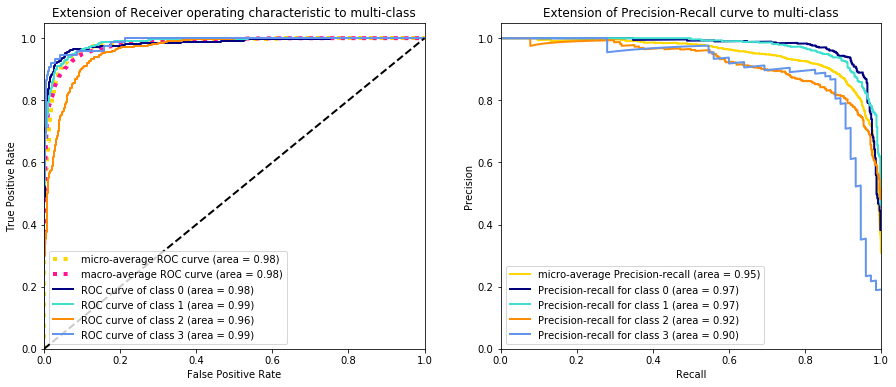

In [38]:
y_pred = nb_pipe.predict_proba(test_df["text"])

plot_roc_pr(y_pred = y_pred, y_test = y_test)

Interestingly the ROC curve for class 3 is now better than class 2 while the opposite is true about the precision/recall curve!

Let's try downsampling the majority classes:

In [39]:
from imblearn.under_sampling import RandomUnderSampler

pipe = Pipeline([('vect',    CountVectorizer()),
                 ('tfidf',   TfidfTransformer()),
                 ('sampler', RandomUnderSampler('majority',random_state=42)),
                 ('model',   MultinomialNB())])

evaluate_pipeline(pipe)

              precision    recall  f1-score   support

          ai       0.00      0.00      0.00       500
          cv       0.77      0.91      0.83       500
          ml       0.47      0.93      0.63       500
          ro       0.00      0.00      0.00        75

    accuracy                           0.59      1575
   macro avg       0.31      0.46      0.37      1575
weighted avg       0.40      0.59      0.46      1575


balanced_accuracy 0.461


/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Downsampling the majority class didnt really help. Imbalance-Learn is quite powerful and has other methods for working with imbalanced data.  Instead let's look at the algorithmic level.

## Weighted Support Vector Machines <a class="anchor" id="sixth-bullet"></a>
-----------------


Support vector machines are examples of **discriminant functions**, i.e. functions that do not give us conditional probabilities. Support vector classifiers do not generalize well beyond the binary classification and use a "one-vs-rest" technique for multi-class classification problems. In our mathematical discussion we will therefore focus on binary classification as a direct subset that matters most. However, even with binary classification we need to reformulate our target variable as $y \in \{-1, 1 \}$ instead of the traditional $y \in \{0, 1 \}$. 

We define the **separating hyperplane** written as $\textbf{w}^{T} \textbf{x} + b $ to be the plane that best separates our classes in feature space.  The vector $\textbf{w} \in \mathbb{R}^{p}$ is coefficients of unknowns along with $b$, called the bias.   The discriminant function then classifies if the point belongs to class (+1) or class (-1) based on which side of the seperating hyperplane the point is:

\begin{align}
h_{\textbf{w}, b} (\textbf{x}) \; &= \; g(\textbf{w}^T {x} + b) \\
&= 
 \left\{
 \begin{array}{rl}
 1, & \text{if} \;  \textbf{w}^T \textbf{x}_i + b  > 0 \\
-1 & \text{if} \;  \textbf{w}^T \textbf{x}_i + b < 0
\end{array}
\right.
\end{align}


Each point $x_{i}$, if classified correctly, should then satisfy the following, 

$$ y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b ) \; > \; 0, \qquad \forall i = 1, \ldots, n$$

The $\textbf{margin}$, $M_{i}$, for a point, $\textbf{x}_{i}$, is defined as the distance from the the point to closest point on the plane.  See the image below:

| ![](images/svm.png) | 
|:--:| 
| *From https://fderyckel.github.io/machinelearningwithr/svm.html* |


From this defintion we see that each point $\textbf{x}_{i}$ should satisfy the equation,

$$ y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b ) \; = M_{i} \; > \; 0, \qquad \forall i = 1, \ldots, n$$

The **geometric margin** is then $M \, = \, \min(M_i)$. If we force $\Vert \textbf{w} \Vert^{2} \, = \, 1$ then maximizing $M$ we ensure that we are classifying correctly. This is called the **hard max classifier** algorithm and summarized as, 

$$ \max_{\textbf{w},b} M \quad \text{s.t.} \quad \Vert \textbf{w} \Vert^{2} = 1, \; \text{ and } \; y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b )  \, \geq \, M, \qquad \forall i = 1, \ldots, n$$


This is a tricky optimization problem and there is often no solution, however, if we allow for some misclassification then this gives us more robustness in our model.  We introduce a slack variable $\xi_{i} \in \{0,1\}$ that is 0 if we classify correctly and 1 if we misclassify the point.  The hard max classification problem is then rewritten as a **soft max problem**:

$$ 
\max_{\textbf{w},b} M \quad \text{s.t.} \quad \Vert \textbf{w} \Vert^{2} = 1 , \; \text{ and } \;  y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b ) \, \geq \, M(1- \xi_{i}) , \quad \forall i = 1, \ldots, n \quad \text{and} \, \sum_{i=1}^{n} \xi_{i} \, \leq \, C
$$

where $C$ is our tolerance for missclassification. Dividing by $M$, this becomes the same as minimizing $ \Vert \textbf{w} \Vert^{2}$ (i.e. maximizing $M$ is the same as minimizing $1/M$) as well as minimizing $C \sum_{i}^{n} \xi_i$ (we recycled the term $C$ since its just a constant). Rearranging terms leads to the equation,

$$ \min_{\textbf{w},b} \, \frac{1}{2} \Vert \textbf{w} \Vert^{2} + C \sum_{i=1}^{n} \xi_i , \quad  \text{s.t.} \quad y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b ) \, \geq \, (1- \xi_{i}) \quad \text{and} \quad \xi_{i} \, \geq \, 0 \qquad \forall i = 1, \ldots, n$$


To handle imbalance with support vector machines we can introduce weights $Q_i$ into our formulation such that the problem we want to optimize is

$$ \min_{\textbf{w},b} \, \frac{1}{2} \Vert \textbf{w} \Vert^{2} + C \sum_{i=1}^{n} Q_i \, \xi_i , \quad  \text{s.t.} \quad y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b ) \, \geq \, (1- \xi_{i}) \quad \text{and} \quad \xi_{i} \, \geq \, 0 \qquad \forall i = 1, \ldots, n$$

The values for the weights, $Q_i$, will then be inversely proprotional to the class size. This adds an additional "cost" to being wrong for the missifying a minority as a majority class. See this [article](https://www.researchgate.net/publication/4202393_Weighted_support_vector_machine_for_data_classification) for more details. I suspect that this will force the model to have much higher precision, as the number of false positives is minimized. To sovle the above optimization problem we introduce Lagrange multiplies $\lambda_i$ and $\alpha_i$ to form the Lagrangian:

\begin{equation}
\min_{\textbf{w},b} \max_{\lambda_{i},\, \alpha_i} \mathcal{L}(\boldsymbol \lambda, \textbf{w}, b) \; = \;
\frac{1}{2} \Vert \textbf{w} \Vert^{2} \, + \, C \sum_{i=1}^{n} Q_i \, \xi_i \, - \, \sum_{i=1}^{n}  \lambda_i \, \left[  \underbrace{y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b ) - 1 + \xi_i}_{\geq 0 \text{ when classified correctly} } \right] \, - \, \sum_{i=1}^{n} \alpha_i \, \xi_i 
\end{equation}

Setting the dertivatives for $\textbf{w}$ and $b$ equal to zero yields:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \textbf{w}}  \; = \; 0 \quad &\rightarrow \quad  \textbf{w} \, = \, \sum_{i=1}^{n} \lambda_{i} \, y_i \, \textbf{x}_i  \\
\frac{\partial \mathcal{L}}{\partial \textbf{b}}  \; = \; 0 \quad &\rightarrow \quad \sum_{i=1}^{n} \lambda_{i} \, y_i  \; = \; 0
\end{align}

Plugging these back in we get the $\textbf{Dual Representation}$ (see [here](http://cs229.stanford.edu/notes/cs229-notes3.pdf) for more details):


\begin{equation}
\max_{\boldsymbol \lambda} \; \sum_{i=1}^{n} \lambda_i - \frac{1}{2} \sum_{i,j=1}^{n} y_{i} \, y_{j}  \, \lambda_{i} \lambda_{j} \, K(\textbf{x}_{i}, \, \textbf{x}_{j}) \quad \text{s.t.} \quad  0 \leq \lambda_{i} \leq Q_i \, C, \quad  \forall i = 1, \ldots, n, \; \text{and} \; \sum_{i=1}^{n} \lambda_{i} \, y_i  \; = \; 0
\end{equation}

Where the kernel $K(\textbf{x}, \textbf{y}) \, = \, \textbf{x}^{T} \textbf{y}$ is fast to compute. Note that while our problem might be high dimensional, i.e. the number of features $p$ is comparable or larger than the number of data points $n$ this is taken care of by the kernel's inner product!

Using $\textbf{w} \, = \, \sum_{i=1}^{n} \lambda_{i} \, y_i \, \textbf{x}_i$ we can rewrite the discriminant prediction function as,

\begin{align}
h_{\textbf{w}, b} (\textbf{x}) \; &= \; \textbf{w}^{T}\textbf{x} + b \\
&= \sum_{i \in \mathcal{S}} \lambda_i \, y_i \, K(\textbf{x}, \textbf{x}_i) + b 
\end{align}

Where $\mathcal{S}$ are the **support vectors**, $\textbf{x}_{i} \, \in \mathbb{R}^{p}$ that satisfy $y_{i} \, (\textbf{w}^{T} \textbf{x}_i + b ) \, = \, 1$.  


For the purposes of this post we'll use the linear support vector classifier [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) as it is fast, automatically adjusts class wieghts and uses one vs rest for handling multi-class problems:

In [40]:
from sklearn.svm import LinearSVC

svm_pipe = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('model',   LinearSVC(class_weight='balanced',
                                           random_state=50))])

evaluate_pipeline(svm_pipe)

              precision    recall  f1-score   support

          ai       0.92      0.90      0.91       500
          cv       0.92      0.92      0.92       500
          ml       0.85      0.89      0.87       500
          ro       0.92      0.80      0.86        75

    accuracy                           0.90      1575
   macro avg       0.90      0.88      0.89      1575
weighted avg       0.90      0.90      0.90      1575


balanced_accuracy 0.877


Very good results!  A little low on the robotics recall, we can see using the Weighted SVM over Upsampled Naive Bayes we traded a little bit of recall for precision.  Let's take a look at the ROC and precision-recall curve:

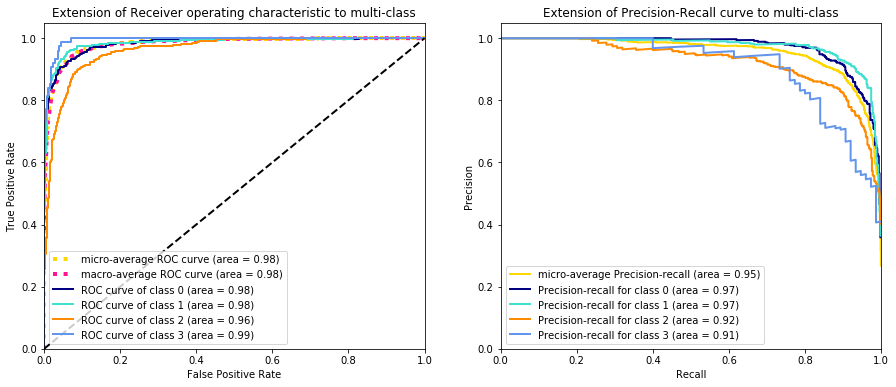

In [42]:
y_pred = svm_pipe.decision_function(test_df["text"])

plot_roc_pr(y_pred = y_pred, y_test = y_test)

## Next Steps <a class="anchor" id="seventh-bullet"></a>
-------------


In this blogpost we covered text classification using Scikit-learn and Imbalance-learn on summaries of papers from arxiv.org.  We went over the basics of term frequency-inverse document frequency, pipelines, Naive Bayes and support vector classifier. We additionally went over the topic of handling imbalanced data both the data level and the algorithm level. In the next post we'll pick up where we left off and cover uses of the NLTK and hyper parameter tunning.